In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix , accuracy_score
from scipy.spatial.distance import cdist 
from scipy import stats
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu 
from skimage import io, exposure 
from skimage.filters import threshold_otsu
import skimage.morphology as skmp
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle 
import pickle
import os
from train import read_binarize, normalize, get_preds, label_img

In [2]:

print(img.shape)img = io.imread('H1-16images/d.bmp')

(750, 600)


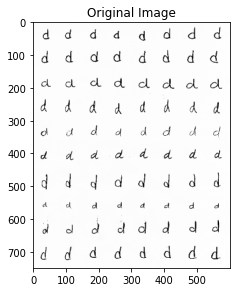

In [3]:
io.imshow(img)
plt.title('Original Image')
io.show()

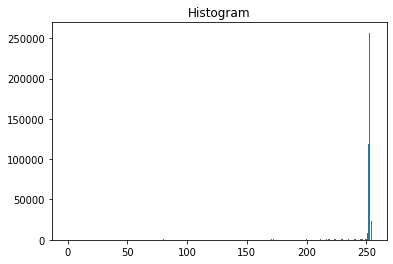

In [4]:
hist = exposure.histogram(img)
plt.bar(hist[1], hist[0])
plt.title('Histogram')
plt.show()

In [5]:
th = threshold_otsu(img)
img_binary = (img < th).astype(np.double)
img_binary = skmp.binary_dilation(img_binary)

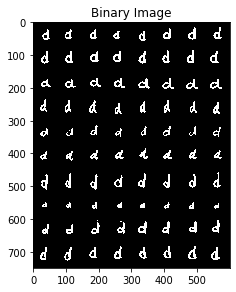

In [6]:
io.imshow(img_binary)
plt.title('Binary Image')
io.show()

In [7]:
img_label = label(img_binary, background=0)

/Users/advithchegu/.local/share/virtualenvs/Computer_Vision-j7KnroHV/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


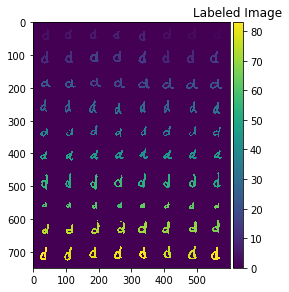

In [8]:
io.imshow(img_label)
plt.title('Labeled Image')
io.show()

In [9]:
print(np.amax(img_label))

83


In [10]:
#store the statistical information
features = []

In [11]:
# build training set
def build_set(minr, minc, maxr, maxc):
    roi = img_binary[minr:maxr, minc:maxc]
    m = moments(roi)
    cr = m[0, 1] / m[0, 0]
    cc = m[1, 0] / m[0, 0]
    center = (cr, cc)
    mu = moments_central(roi, center)
    nu = moments_normalized(mu)
    hu = moments_hu(nu)
    features.append(hu)

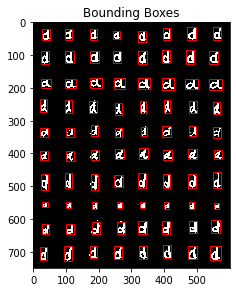

In [12]:
regions = regionprops(img_label)
io.imshow(img_binary)
ax = plt.gca()
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    height = maxr - minr
    width = maxc - minc
    if width > 10 and height > 10:
        build_set(minr, minc, maxr, maxc)
        ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor = 'red', linewidth = 1))
ax.set_title('Bounding Boxes')
# plt.savefig("a_train_annot.png")

io.show()

In [13]:
print("Height: ", len(features), "Width: ", len(features[0]))

Height:  80 Width:  7


In [14]:
# go through all the images and get all the features
features = {}
regions = {}
directory_name = './H1-16images/'
for file_name in sorted(os.listdir(directory_name)):
    f = file_name.replace('.bmp', '')
    if f not in ('test1', 'test2'):
        features[f], regions[f] = read_binarize(directory_name + file_name, f)

In [15]:
combined, flat, normalized, mean, std_dev = normalize(features)
print('mean: ', mean)
print('standard dev: ', std_dev)

mean:  870345.8726826119
standard dev:  70276887.85572113


In [16]:
# keeps track of the locations of each letter array
letter_locs = {}
count = 0

# create the label vector
for k in normalized.keys():
    for i in range(count, count+len(normalized[k])):
        letter_locs[i] = k
    count += len(normalized[k])
conc = np.concatenate([normalized[k] for k in normalized])

# K nearest neighbors
pred, real = get_preds(conc, conc, 5, letter_locs, letter_locs)
acc = accuracy_score(real, pred)
print(acc)

0.6609375


In [17]:
# label the training images
count = 0
for k in normalized.keys():
    labels = pred[count:count+len(normalized[k])]
    count += len(normalized[k])
    label_img(k, labels, regions[k])
    # print(labels)

/Users/advithchegu/.local/share/virtualenvs/Computer_Vision-j7KnroHV/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/Users/advithchegu/.local/share/virtualenvs/Computer_Vision-j7KnroHV/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


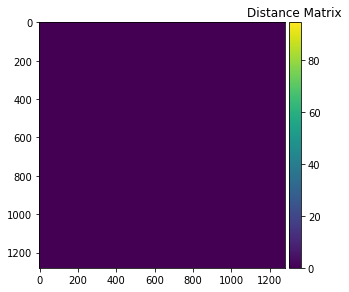

In [18]:
D = cdist(conc, conc)
io.imshow(D)
plt.title('Distance Matrix')
io.show()

/Users/advithchegu/.local/share/virtualenvs/Computer_Vision-j7KnroHV/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


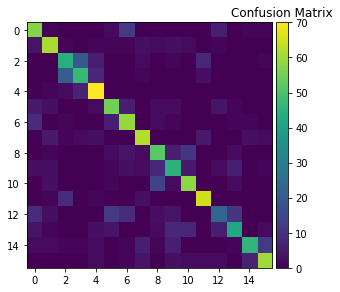

In [19]:
confm = confusion_matrix(real, pred)
io.imshow(confm)
plt.title('Confusion Matrix')
io.show()

In [20]:
letters_mapping_1 = np.repeat(['a', 'd', 'm', 'n', 'o', 'p', 'q', 'r', 'u', 'w'], 7)
letters_mapping_2 = np.repeat(['f', 'h', 'k', 's', 'x', 'z', 'a', 'o', 'w', 'm'], 8)
test_1, test_regions_1 = read_binarize('H1-16images/test1.bmp', 'test_1')
test_2, test_regions_2 = read_binarize('H1-16images/test2.bmp', 'test_2')
normalized_test_1  = (test_1 - mean)/std_dev
normalized_test_2  = (test_2 - mean)/std_dev

In [21]:
# K nearest neighbors for first test
pred, real = get_preds(conc, normalized_test_1, 5, letter_locs, letters_mapping_1)
acc = accuracy_score(pred, real)
print('First test accuracy: ', acc)
label_img('test1', letters_mapping_1, test_regions_1)

second_mapping = np.repeat(letters_mapping_2, 8)
pred, real = get_preds(conc, normalized_test_2, 5, letter_locs, letters_mapping_2)
acc = accuracy_score(pred, real)
print('Second test accuracy: ', acc)
label_img('test2', letters_mapping_2, test_regions_2)

First test accuracy:  0.42857142857142855
Second test accuracy:  0.3875
